In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd


/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_2025.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_1571.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_227.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_926.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_907.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_528.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_844.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_830.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_2215.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_1203.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_1756.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_299.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_502.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_875.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_755.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_2200.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_1909.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_1960.jpg
/k

In [5]:
import numpy as np
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import os
from glob import glob
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
# from network import Net
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')
    

In [6]:
# Global parameters

# If USE_CUDA is True, computations will be done using the GPU (may not work in all systems)
# This will make the calculations happen faster
USE_CUDA = torch.cuda.is_available()

DATASET_PATH = '/kaggle/input/eurosat-rgb'

BATCH_SIZE = 64 # Number of images that are used for calculating gradients at each step

NUM_EPOCHS = 25 # Number of times we will go through all the training images. Do not go over 25

LEARNING_RATE = 0.001 # Controls the step size
MOMENTUM = 0.9 # Momentum for the gradient descent
WEIGHT_DECAY = 0.0005

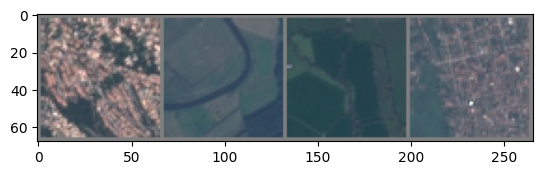

Labels:  2750  2750  2750  2750


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms

# Define dataset transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the dataset
data_dir = DATASET_PATH  # Point to the RGB dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Create a DataLoader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# Get some random images
data_iter = iter(data_loader)
images, labels = next(data_iter)  # Fetch the next batch

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display images
imshow(torchvision.utils.make_grid(images))

# Print labels
class_names = dataset.classes
print('Labels:', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))


In [13]:
class_names = dataset.classes
print("Classes: ", class_names)
print("Number of images: ", len(dataset))

Classes:  ['2750']
Number of images:  27000


In [14]:
import shutil
import random

# Define paths
src_directory = '/kaggle/input/eurosat-rgb/2750'  # Update this to your dataset path in Kaggle
dest_directory = './split_dataset/'  # Where to save the split dataset

# Create directories for train and test sets
os.makedirs(os.path.join(dest_directory, 'train'), exist_ok=True)
os.makedirs(os.path.join(dest_directory, 'test'), exist_ok=True)

# Function to split data
def split_data(src_dir, dest_dir, split_ratio=0.8):
    # Iterate through each class
    for class_name in os.listdir(src_dir):
        class_path = os.path.join(src_dir, class_name)
        
        if os.path.isdir(class_path):
            # Create class directories in train and test
            os.makedirs(os.path.join(dest_dir, 'train', class_name), exist_ok=True)
            os.makedirs(os.path.join(dest_dir, 'test', class_name), exist_ok=True)
            
            # Get all images in the class
            images = os.listdir(class_path)
            random.shuffle(images)  # Shuffle images
            
            # Split the images
            split_index = int(len(images) * split_ratio)
            train_images = images[:split_index]
            test_images = images[split_index:]

            # Move images to respective directories
            for img in train_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(dest_dir, 'train', class_name, img))
            for img in test_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(dest_dir, 'test', class_name, img))

# Execute the split
split_data(src_directory, dest_directory)


In [15]:
SPLITTED_DATASET_PATH = '/kaggle/working/split_dataset'

In [16]:
train_dir = os.path.join(SPLITTED_DATASET_PATH, 'train', '2750')
test_dir = os.path.join(SPLITTED_DATASET_PATH, 'test', '2750')

In [17]:
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
    print(f"Removed folder: {train_dir}")

# Remove the '2750' folder from the test directory if it exists
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    print(f"Removed folder: {test_dir}")

In [18]:
# Create datasets and data loaders
# Transformations

from torchvision import datasets, models, transforms
data_transforms = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(os.path.join(SPLITTED_DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)


test_dataset = datasets.ImageFolder(os.path.join(SPLITTED_DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes

print('Dataloaders OK')
test_loader

Dataloaders OK


In [94]:
#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 4 feature maps is 
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(64-3+2(1)/1)+1] = 64 (padding type is same)
        self.batchnorm1 = nn.BatchNorm2d(4)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
  
        #After max pooling, the output of each feature map is now 64/2 =32
        self.cnn2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        #Output size of each of the 32 feature maps
        self.batchnorm2 = nn.BatchNorm2d(8)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #After max pooling, the output of each feature map is 32/2 = 16
        #Flatten the feature maps. You have 8 feature maps, each of them is of size 16x16 --> 8*16*16 = 2048
        self.fc1 = nn.Linear(in_features=8*16*16, out_features=32)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=32, out_features=10)
        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        
        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before! 
        #It will take the shape (batch_size, 2048)
        out = out.view(x.size(0), -1)
        
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        #out = self.droput(out)
        out = self.fc2(out)
        return out

In [95]:
# Create network
model = CNN()
if USE_CUDA:
    model = model.cuda()  
    
print('Network OK')

Network OK


In [96]:
# Define criterion, optimizer, and scheduler

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [97]:
# Main loop
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
epochs = []

for epoch in range(1, NUM_EPOCHS+1):
    print(f'\n\nRunning epoch {epoch} of {NUM_EPOCHS}...\n')
    epochs.append(epoch)

    #-------------------------Train-------------------------
    
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()  # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_loader):
       
        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()        
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        iter_loss += loss.item()  # Accumulate the loss
        optimizer.zero_grad() # Clear off the gradient in (w = w - gradient)
        loss.backward()   # Backpropagation 
        optimizer.step()  # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum()
        correct += (predicted == labels).sum().item() 
        iterations += 1
        
    scheduler.step()
        
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))   
     
    #-------------------------Test--------------------------
    
    correct = 0
    iterations = 0
    testing_loss = 0.0
    
    model.eval()  # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_loader):

        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = criterion(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum()
        correct += (predicted == labels).sum().item() 
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
   
    print(f'\nEpoch {epoch} validation results: Loss={test_loss[-1]} | Accuracy={test_accuracy[-1]}\n')





Running epoch 1 of 25...


Epoch 1 validation results: Loss=1.189858552321647 | Accuracy=54.86490588949605



Running epoch 2 of 25...


Epoch 2 validation results: Loss=0.8759948951960768 | Accuracy=69.39131754705525



Running epoch 3 of 25...


Epoch 3 validation results: Loss=0.8135903725418651 | Accuracy=69.18639951426837



Running epoch 4 of 25...


Epoch 4 validation results: Loss=0.7590341571248272 | Accuracy=72.66241651487553



Running epoch 5 of 25...


Epoch 5 validation results: Loss=0.8202633840276055 | Accuracy=71.26593806921676



Running epoch 6 of 25...


Epoch 6 validation results: Loss=0.6056538540417853 | Accuracy=78.90862173649059



Running epoch 7 of 25...


Epoch 7 validation results: Loss=0.5886438429283286 | Accuracy=79.06800242865816



Running epoch 8 of 25...


Epoch 8 validation results: Loss=0.5200576537008424 | Accuracy=82.27079538554949



Running epoch 9 of 25...


Epoch 9 validation results: Loss=0.5149678198566425 | Accuracy=82.39981785063752





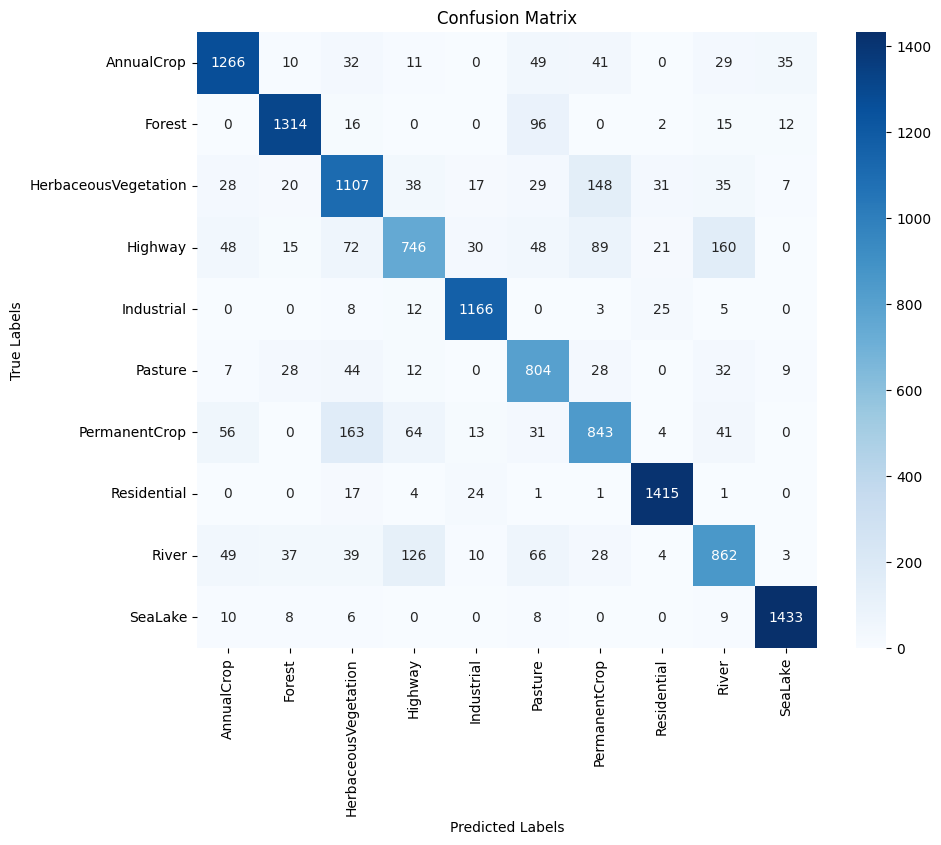

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculations for validation
with torch.no_grad():
    for inputs, labels in test_loader:
        if USE_CUDA:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Visualize confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


* Residential and SeaLake classes are classified very accurately, with minimal misclassification.
 
* Highway, Pasture, and PermanentCrop show higher misclassification, particularly confusing with similar categories like HerbaceousVegetation and AnnualCrop.
 
* River and Industrial classes have decent accuracy but still show misclassification with nearby categories like Forest and SeaLake.

In [99]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report:')
print(report)


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.86      0.86      0.86      1473
              Forest       0.92      0.90      0.91      1455
HerbaceousVegetation       0.74      0.76      0.75      1460
             Highway       0.74      0.61      0.67      1229
          Industrial       0.93      0.96      0.94      1219
             Pasture       0.71      0.83      0.77       964
       PermanentCrop       0.71      0.69      0.70      1215
         Residential       0.94      0.97      0.95      1463
               River       0.72      0.70      0.71      1224
             SeaLake       0.96      0.97      0.96      1474

            accuracy                           0.83     13176
           macro avg       0.82      0.83      0.82     13176
        weighted avg       0.83      0.83      0.83     13176



* Overall accuracy is 83%, indicating a well-performing model across the classes.

* Residential, SeaLake, and Industrial classes have high precision and recall, with scores above 0.90, reflecting strong classification performance.

* Highway and PermanentCrop show relatively lower performance, with precision and recall around 0.70, indicating room for improvement in distinguishing these classes.

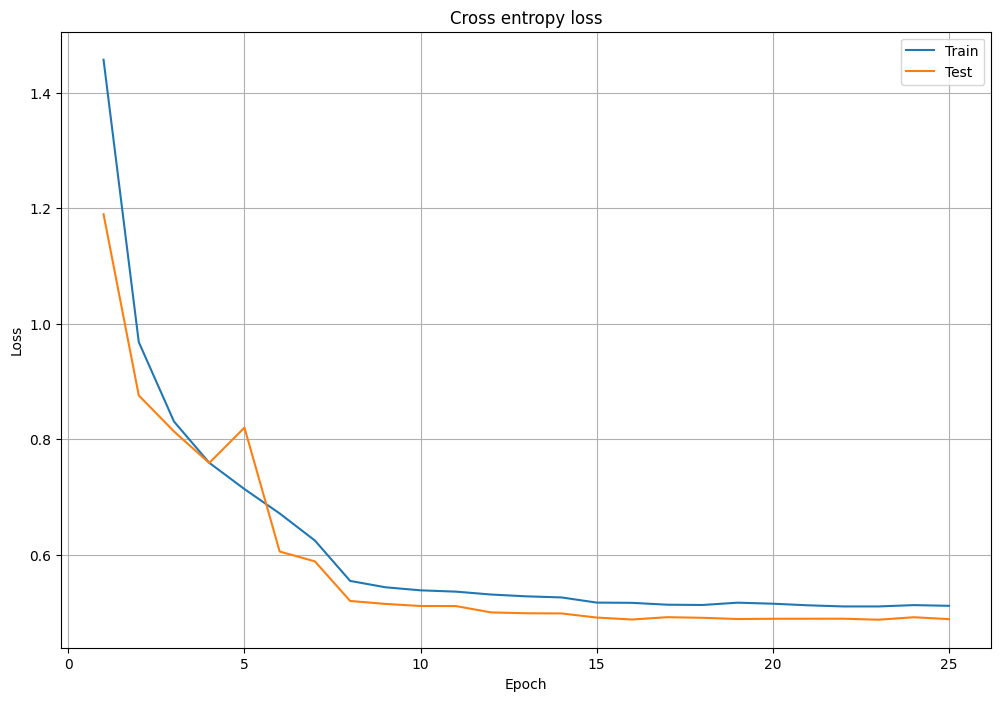

In [100]:
    plt.figure(figsize=(12, 8), num=1)
    plt.clf()
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, test_loss, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Cross entropy loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('outputs/01-loss-cnn.pdf')
    


Consistent Decrease in Training Loss:

*     The training loss started at 1.46 and gradually decreased to 0.51 over 25 epochs, indicating that the model is learning and improving its performance over time.

#
Stable Validation Loss:

* The validation loss initially dropped from 1.19 to around 0.49 after a few epochs, showing stabilization. This suggests the model's performance is consistent and isn't overfitting.

#
No Significant Overfitting:

* Since both the training and validation losses decrease and converge around similar values, there is no evidence of overfitting, and the model generalizes well to unseen data.

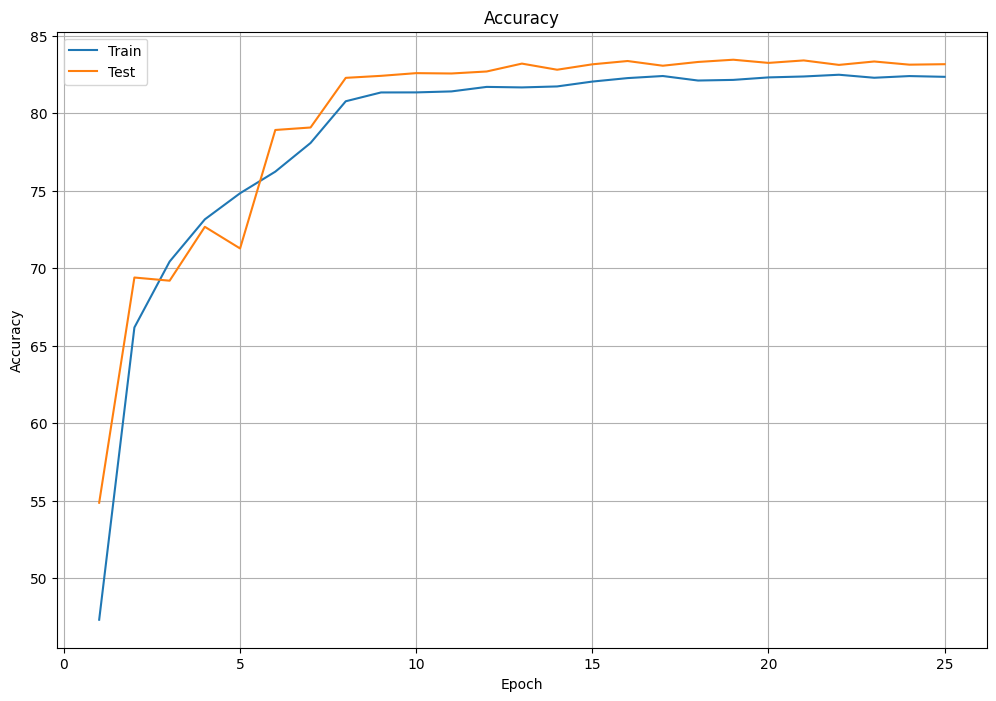

In [101]:
    plt.figure(figsize=(12, 8), num=2)
    plt.clf()
    plt.plot(epochs, train_accuracy, label='Train')
    plt.plot(epochs, test_accuracy, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig('outputs/02-accuracy-cnn.pdf')

**Training Accuracy**: Increased significantly from 47.32% to 82.39% over 25 epochs, showing effective learning.

**Test Accuracy**: Reached 83.15%, indicating good generalization to unseen data and minimal overfitting.

**Stability**: Training and test accuracies are converging around 83%, reflecting a well-optimized model.

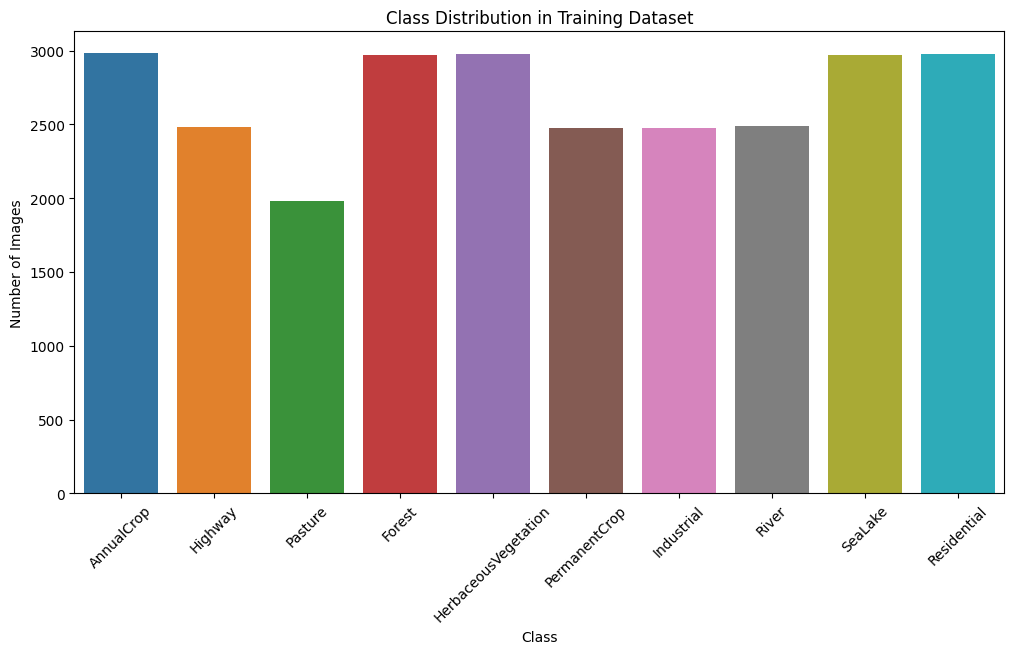

In [102]:
data_dir = SPLITTED_DATASET_PATH 
class_names = os.listdir(os.path.join(data_dir, 'train'))

class_counts = {class_name: len(os.listdir(os.path.join(data_dir, 'train', class_name))) for class_name in class_names}
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Visualize Class Distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=class_counts_df, x='Class', y='Count')
plt.xticks(rotation=45)
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


**Balanced Classes: Most classes have 2400 samples, ensuring good representation.**

**Smaller Classes: Highway, Pasture, and others have fewer samples, with Pasture being the smallest at 1600.**

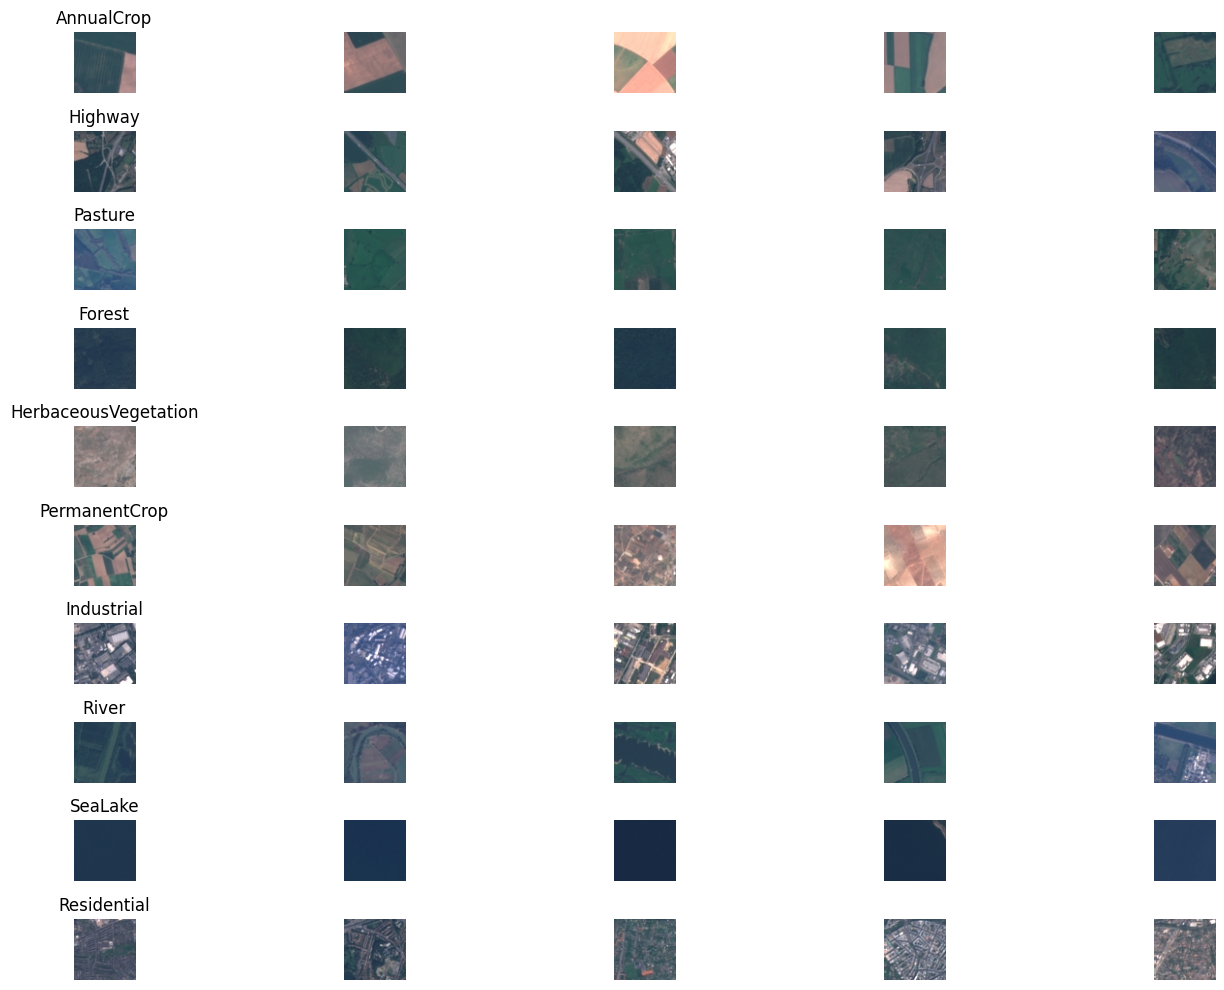

In [103]:
def display_sample_images(class_names, data_dir, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        images = os.listdir(os.path.join(data_dir, 'train', class_name))
        selected_images = np.random.choice(images, num_samples, replace=False)
        
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(data_dir, 'train', class_name, img_name)
            img = Image.open(img_path)
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.title(class_name)

    plt.tight_layout()
    plt.show()

display_sample_images(class_names, data_dir)


In [104]:
image_sizes = []

for class_name in class_names:
    images = os.listdir(os.path.join(data_dir, 'train', class_name))
    for img_name in images:
        img_path = os.path.join(data_dir, 'train', class_name, img_name)
        img = Image.open(img_path)
        image_sizes.append(img.size)

image_sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
print(image_sizes_df.describe())


         Width   Height
count  26784.0  26784.0
mean      64.0     64.0
std        0.0      0.0
min       64.0     64.0
25%       64.0     64.0
50%       64.0     64.0
75%       64.0     64.0
max       64.0     64.0


**All images in the dataset have a consistent resolution of 64x64 pixels. This uniformity simplifies preprocessing since no resizing is required.**

In [105]:
print(f'Final train loss: {train_loss[-1]}')
print(f'Final test loss: {test_loss[-1]}')
print(f'Final train accuracy: {train_accuracy[-1]}')
print(f'Final test accuracy: {test_accuracy[-1]}')

Final train loss: 0.5116878995462932
Final test loss: 0.4886099172991167
Final train accuracy: 82.33646953405018
Final test accuracy: 83.1511839708561


# **ResNet**

In [8]:
#Create the model class with ResNet
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16 
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16) 
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0], 1)
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(16)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(conv3x3(self.in_channels, out_channels, stride=stride),
                                       nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        return out
    

In [10]:
# Create network
model = ResNet(ResidualBlock, [2, 2, 2])
if USE_CUDA:
    model = model.cuda()  

In [11]:
# Define criterion, optimizer, and scheduler

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [21]:
# Main loop
train_loss_resnet = []
train_accuracy_resnet = []
test_loss_resnet = []
test_accuracy_resnet = []
epochs = []

for epoch in range(1, NUM_EPOCHS+1):
    print(f'\n\nRunning epoch {epoch} of {NUM_EPOCHS}...\n')
    epochs.append(epoch)

    #-------------------------Train-------------------------
    
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()  # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_loader):
        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()        
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        iter_loss += loss.item()  # Accumulate the loss
        optimizer.zero_grad() # Clear off the gradient in (w = w - gradient)
        loss.backward()   # Backpropagation 
        optimizer.step()  # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1
        
    scheduler.step()
        
    # Record the training loss
    train_loss_resnet.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy_resnet.append((100 * correct / len(train_dataset)))   
     
    #-------------------------Test--------------------------
    
    correct = 0
    iterations = 0
    testing_loss= 0.0
    
    model.eval()  # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_loader):

        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = criterion(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        
        iterations += 1

    # Record the Testing loss
    test_loss_resnet.append(testing_loss/iterations)
    # Record the Testing accuracy
    test_accuracy_resnet.append((100 * correct / len(test_dataset)))
   
    print(f'\nEpoch {epoch} validation results: Loss={test_loss_resnet[-1]} | Accuracy={test_accuracy_resnet[-1]}\n')





Running epoch 1 of 25...


Epoch 1 validation results: Loss=0.49592359742040143 | Accuracy=82.87037037037037



Running epoch 2 of 25...


Epoch 2 validation results: Loss=0.4257642334327102 | Accuracy=85.62962962962963



Running epoch 3 of 25...


Epoch 3 validation results: Loss=0.47190629673354767 | Accuracy=84.9074074074074



Running epoch 4 of 25...


Epoch 4 validation results: Loss=0.4364473329747424 | Accuracy=84.46296296296296



Running epoch 5 of 25...


Epoch 5 validation results: Loss=0.3562305392149617 | Accuracy=88.11111111111111



Running epoch 6 of 25...


Epoch 6 validation results: Loss=0.21644502743421232 | Accuracy=92.92592592592592



Running epoch 7 of 25...


Epoch 7 validation results: Loss=0.21503021289758822 | Accuracy=93.07407407407408



Running epoch 8 of 25...


Epoch 8 validation results: Loss=0.20529021010460222 | Accuracy=93.35185185185185



Running epoch 9 of 25...


Epoch 9 validation results: Loss=0.20357216634404132 | Accuracy=93.388888888888

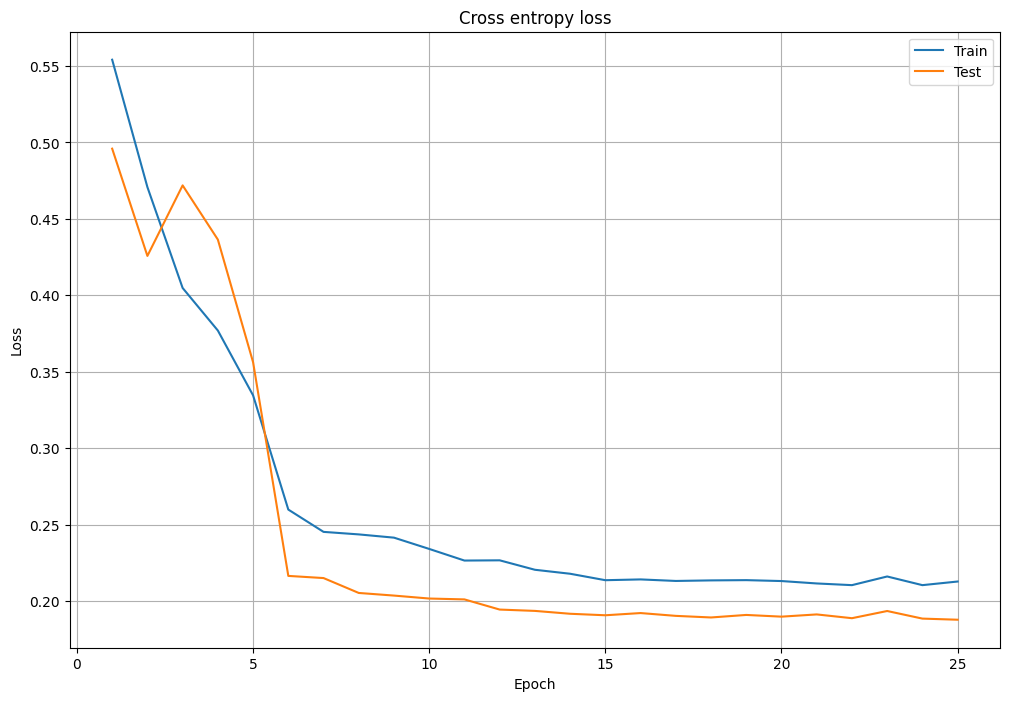

In [22]:
    # Plot and save
    plt.figure(figsize=(12, 8), num=1)
    plt.clf()
    plt.plot(epochs, train_loss_resnet, label='Train')
    plt.plot(epochs, test_loss_resnet, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Cross entropy loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('outputs/01-loss-resnet.pdf')

**Effective Learning**: ResNet's cross-entropy loss decreases from 0.554 to 0.210, indicating strong convergence and effective learning.

**Architecture Advantage**: ResNet's skip connections enhance gradient flow, allowing for better feature learning compared to traditional CNNs.

**Lower Final Loss**: The loss values suggest that ResNet outperforms typical CNNs, likely leading to improved accuracy in predictions.

**Best Choice**: Overall, ResNet is a strong choice for complex image classification tasks due to its depth and efficiency in minimizing loss.

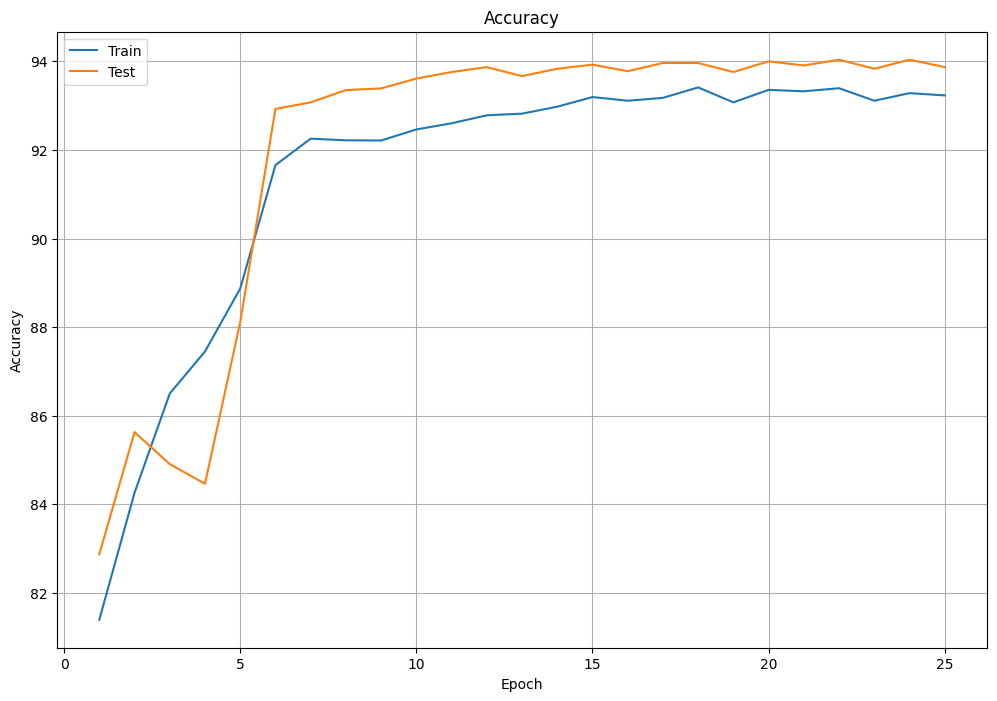

In [23]:
    plt.figure(figsize=(12, 8), num=2)
    plt.clf()
    plt.plot(epochs, train_accuracy_resnet, label='Train')
    plt.plot(epochs, test_accuracy_resnet, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig('outputs/02-accuracy-resnet.pdf')

**Overall Improvement**: The training accuracy shows a steady increase from 81.39% to 93.39%, indicating effective learning and model adaptation over epochs.

**Validation Stability**: Validation accuracy fluctuates around 93%, with a peak of 94%, demonstrating that the model is robust and generalizes well on unseen data.

**Convergence**: Both training and validation accuracies suggest convergence, with validation accuracy stabilizing around 93-94%, indicating no significant overfitting.

**Optimal Choice**: The high accuracy levels achieved by ResNet affirm it as an excellent choice for image classification tasks, effectively capturing complex patterns in the data.

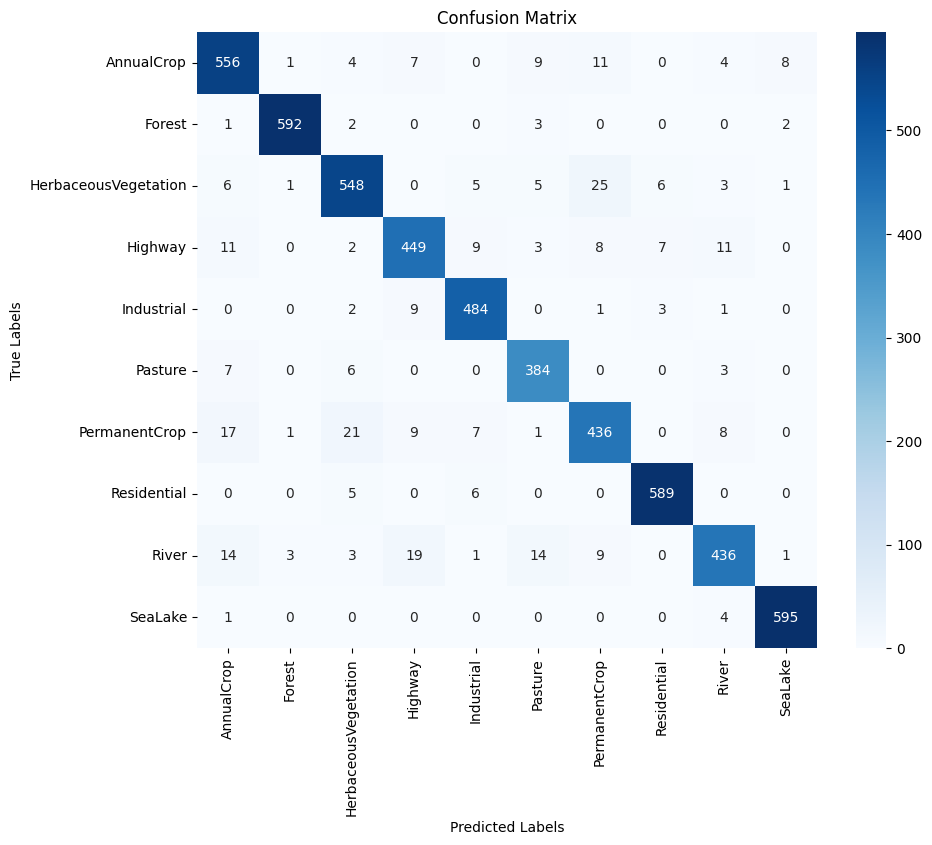

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculations for validation
with torch.no_grad():
    for inputs, labels in test_loader:
        if USE_CUDA:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
conf_matrix_resnet = confusion_matrix(all_labels, all_preds)

# Visualize confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


**Strong Performance**: Classes 0, 1, and 3 show high correct predictions (556, 592, and 449), indicating effective classification.

**Misclassifications**: Class 2 has notable confusion with class 6 (25 misclassifications), suggesting overlap in features.

**Low Error Rates**: Overall, misclassifications are relatively low, with most classes maintaining a strong accuracy.

In [31]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report:')
print(report)


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.93      0.92       600
              Forest       0.99      0.99      0.99       600
HerbaceousVegetation       0.92      0.91      0.92       600
             Highway       0.91      0.90      0.90       500
          Industrial       0.95      0.97      0.96       500
             Pasture       0.92      0.96      0.94       400
       PermanentCrop       0.89      0.87      0.88       500
         Residential       0.97      0.98      0.98       600
               River       0.93      0.87      0.90       500
             SeaLake       0.98      0.99      0.99       600

            accuracy                           0.94      5400
           macro avg       0.94      0.94      0.94      5400
        weighted avg       0.94      0.94      0.94      5400



**High Overall Performance**: The model achieves an accuracy of 94%, demonstrating effective classification across all classes.

**Consistent Precision and Recall**: Most classes, particularly Forest (0.99) and Residential (0.98), show high precision and recall, indicating reliable predictions and minimal false positives.

**Areas for Improvement**: Classes like PermanentCrop (0.89 precision, 0.87 recall) and River (0.93 precision, 0.87 recall) show slightly lower scores, highlighting potential areas for further refinement to boost overall model performance.

In [ ]:
_____

___________________________________________________________________________________________


# Conclusion
**Overall, the ResNet model outperforms the CNN in terms of classification accuracy and reliability, making it a preferable choice for satellite image classification tasks. However, both models have shown good results, and future enhancements could focus on improving the performance in the classes where they struggle the most.**